## Импорт бибилиотек и функции

In [ ]:
# импорт нужных бибилиотек
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Загрузка набора данных

In [ ]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Dec 21 10:14 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d emmarex/plantdisease

 98% 647M/658M [00:03<00:00, 213MB/s]
100% 658M/658M [00:03<00:00, 173MB/s]


## Чтение данных

In [ ]:
# разархивирование данных
!unzip "/content/plantdisease.zip" -d "/content/plantdisease"

In [ ]:
disease_types = ['yellow_leaf', 'healthy']
data_dir = '/content/plantdisease/PlantVillage/'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

df = pd.DataFrame(train_data, columns=['file_path', 'disease_id','disease_type'])

In [ ]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X = np.zeros((df.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(df['file_path'].values)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X = X / 255.
print('Train Shape: {}'.format(X.shape))

4800it [00:07, 627.56it/s]


Train Shape: (4800, 64, 64, 3)


In [ ]:
y = df['disease_id'].values

# Деление на выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер валидационной выборки: {X_val.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер тренировочной выборки: 3072
Размер валидационной выборки: 768
Размер тестовой выборки: 960


# Загрузка модели

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model

In [ ]:
model = VGG16()

553467096/553467096 [==============================] - 8s 0us/step


# Фильтры сверточной нейронной сети

In [ ]:
for layer in model.layers:

    if 'conv' not in layer.name:
        continue
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


In [ ]:
# retrieve weights from the second hidden layer
filters, bias = model.layers[1].get_weights()

In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

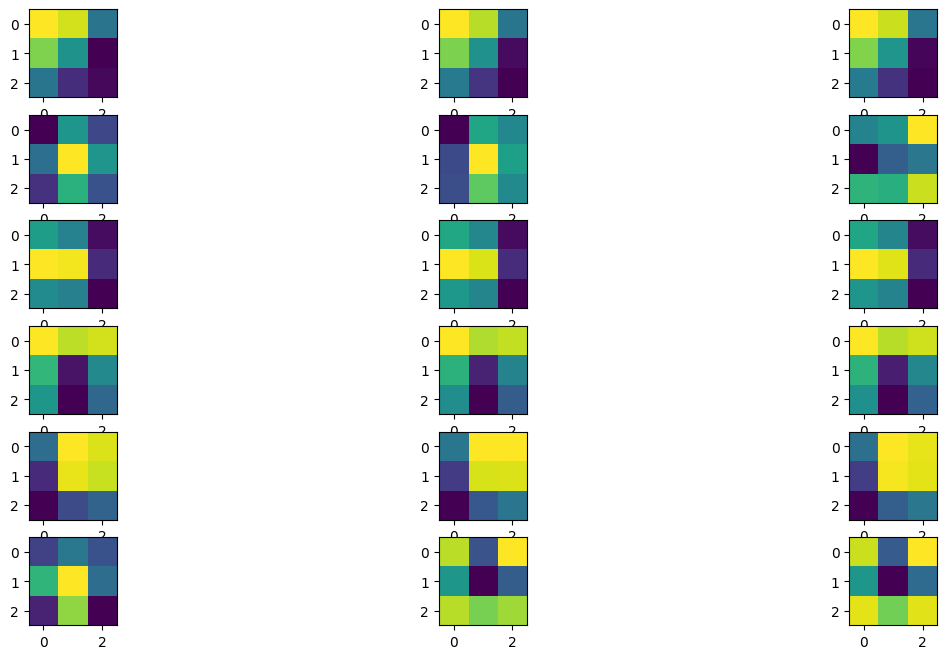

In [ ]:
n_filters = 6
ix = 1
fig = plt.figure(figsize=(15, 8))
for i in range(n_filters):
    # get the filters
    f = filters[:, :, :, i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters, 3, ix)
        plt.imshow(f[:, :, j])
        ix+=1
#plot the filters
plt.show()

In [ ]:
from numpy import expand_dims

In [ ]:
image_class_yellow_leaf = load_img(os.path.join(data_dir, df["file_path"][0]) , target_size=(224, 224))
image_class_healthy = load_img(os.path.join(data_dir, df["file_path"][4797]) , target_size=(224, 224))

# convert the image to an array
image_class_yellow_leaf = img_to_array(image_class_yellow_leaf)
image_class_healthy = img_to_array(image_class_healthy)

# expand dimensions so that it represents a single 'sample'
image_class_yellow_leaf = expand_dims(image_class_yellow_leaf, axis=0)
image_class_healthy = expand_dims(image_class_healthy, axis=0)

In [ ]:
image_class_yellow_leaf = preprocess_input(image_class_yellow_leaf)
image_class_healthy = preprocess_input(image_class_healthy)

In [ ]:
blocks = [2, 5, 9]
outputs = [model.layers[i].output for i in blocks]

model = Model(inputs=model.inputs, outputs=outputs)

# Промежуточные активации

In [ ]:
feature_map_yellow_leaf = model.predict(image_class_yellow_leaf)
feature_map_healthy = model.predict(image_class_healthy)

1/1 [==============================] - 0s 235ms/step


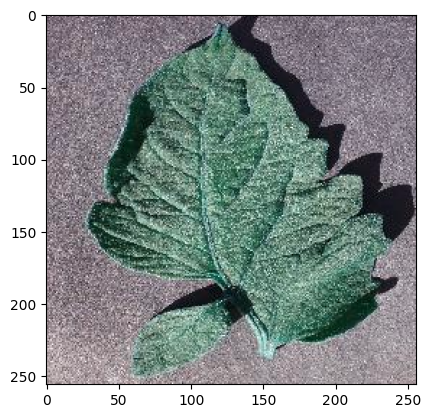

In [ ]:
plt.imshow(cv2.imread(os.path.join(data_dir, df["file_path"][4797])))

In [ ]:
def feature_map(feature_map_class):
  for i,fmap in zip(blocks, feature_map_class):
    fig = plt.figure(figsize=(8, 5))
    fig.suptitle("BLOCK_{}".format(i), y=.7)
    for i in range(1, 5):
        plt.subplot(1, 4, i)
        plt.imshow(fmap[0, :, :, i-1])

plt.show()

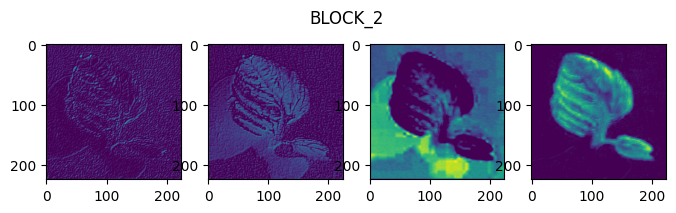

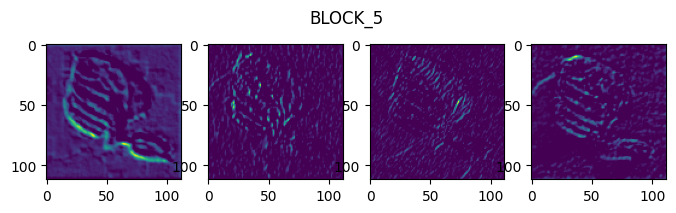

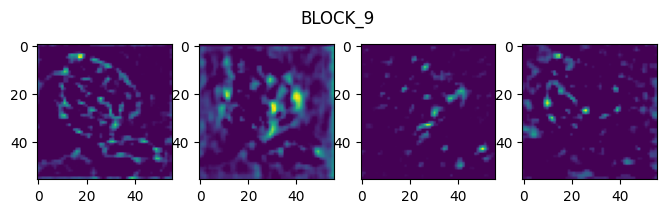

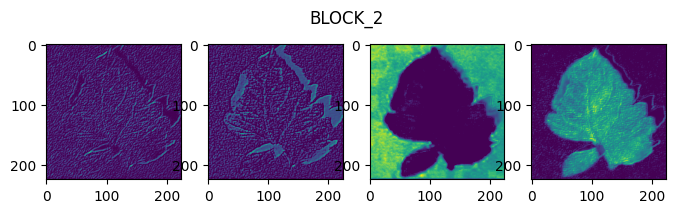

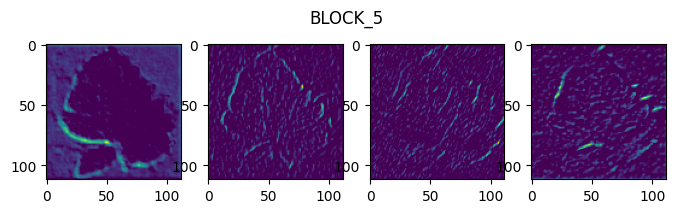

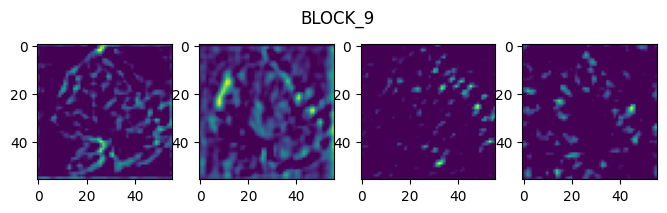

In [ ]:
feature_map(feature_map_yellow_leaf)
feature_map(feature_map_healthy)

# Shap

In [ ]:
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.6 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/DL/Радмир/img_class.h5')

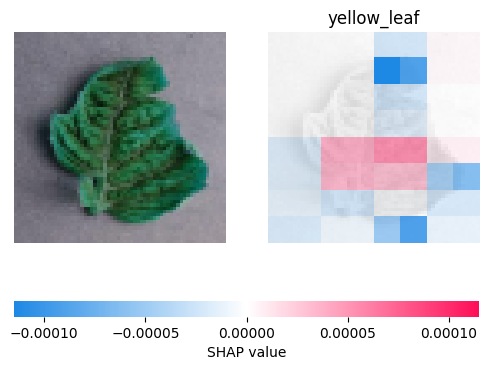

In [ ]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=disease_types)

shap_values = explainer(X_test[:1], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

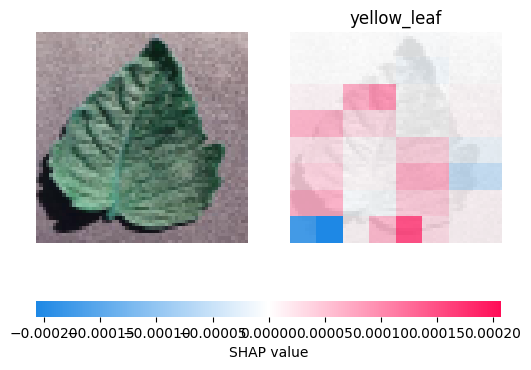

In [ ]:
masker = shap.maskers.Image("blur(28,28)", X_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=disease_types)

shap_values = explainer(X_test[1:2], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)